# Разбиение на КСС внутри time steps

## Создаем граф ts <-> addr1 <-> addr2

In [111]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [112]:
addr_to_tx = pd.read_csv("../dataset/Elliptic++ Dataset/AddrTx_edgelist.csv")
tx_to_addr = pd.read_csv("../dataset/Elliptic++ Dataset/TxAddr_edgelist.csv")
tx_features = pd.read_csv("../dataset/Elliptic++ Dataset/txs_features.csv")[["txId", "Time step"]]

In [113]:
addr_to_addr_edges = pd.merge(
    left=addr_to_tx,
    right=tx_to_addr,
    how="left",
    left_on="txId",
    right_on="txId"
)
addr_to_addr_edges = pd.merge(
    left=addr_to_addr_edges,
    right=tx_features,
    how="left",
    left_on="txId",
    right_on="txId"
)
addr_to_addr_edges.drop("txId", axis=1, inplace=True)
addr_to_addr_edges = addr_to_addr_edges[addr_to_addr_edges["input_address"] !=addr_to_addr_edges["output_address"] ]
addr_to_addr_edges

,input_address,output_address,Time step
0,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a,1GASxu5nMntiRKdVtTVRvEbP965G51bhHH,1
2,13Lhad3SAmu2vqYg2dxbNcxH7LE77kJu2w,1GFdrdgtG34GChM8SMpMwcXFc4nYbH1A5G,1
3,1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz,19q57SeCEzTnWrWVXA43nZzhSiXkYggh7c,1
4,1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz,1Kk1NVYnCE8ALXDhgMM6HqTt1jDSvi6QBA,1
5,16zs5SVSyADh5WrLNbZbpRLsBsN5uEzgeK,1ExQobam8YdTkwATZjTZgevwrheSkUFVN1,1
...,...,...,...
2868957,1HdnGvuc21Y4QfBEHUc3NFRJhGywdSFUb,1PAsnUQu9jgMpzucgLwYVuqmtPq489rnyp,49
2868958,3MfN5to5K5be2RupWE8rjJHQ6V9L8ypWeh,1Ct6Sx8uKTubXPcuLX5jSKb6QKMcqf1Ybj,49
2868960,3DzbpEogZ1mn9FgCHcmzYPLDbV9GuxYHpi,38jMiiZs2C5n5MPkyc5pSA7wwW6H4p6hPa,49
2868961,34yD1sQg6C16aANCtibYXRj5NsX6tt4v5R,3G9b7hWZccuft1V4eGUcZqTZaxsqx699bM,49


<Axes: xlabel='Time step', ylabel='Count'>

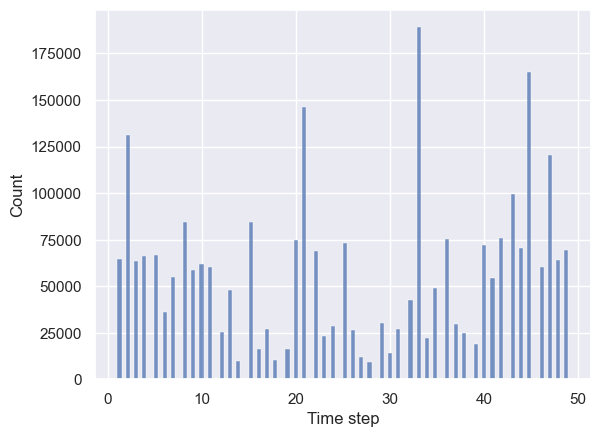

In [114]:
sns.histplot(
    addr_to_addr_edges["Time step"]
)

In [115]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
%autoreload 2

from scc_utils import (
    get_scc_data
)

In [117]:
addr_to_addr_edges["Time step"].max()

49

In [118]:
addr_to_output_cnt = addr_to_addr_edges.groupby("input_address")["output_address"].nunique().reset_index() \
    .rename(columns={"input_address": "address", "output_address": "output_cnt"})
addr_to_input_cnt = addr_to_addr_edges.groupby("output_address")["input_address"].nunique().reset_index() \
    .rename(columns={"output_address": "address", "input_address": "input_cnt"})

cutoff = np.quantile(addr_to_output_cnt["output_cnt"], 0.995)

In [119]:
cutoff

107.0

In [120]:
good_output = addr_to_output_cnt[addr_to_output_cnt["output_cnt"] <= cutoff]["address"]
good_input = addr_to_input_cnt[addr_to_input_cnt["input_cnt"] <= cutoff]["address"]

bad_output = addr_to_output_cnt[addr_to_output_cnt["output_cnt"] > cutoff]["address"]
bad_input = addr_to_input_cnt[addr_to_input_cnt["input_cnt"] > cutoff]["address"]

### Проверим классы среди плохих

In [121]:
addr_classes = pd.read_csv("../dataset/Elliptic++ Dataset/wallets_classes.csv")

In [122]:
# bad input
addr_classes[addr_classes["address"].isin(bad_input)]["class"].value_counts()

class
2    344
3    308
1     20
Name: count, dtype: int64

In [123]:
# bad output
addr_classes[addr_classes["address"].isin(bad_output)]["class"].value_counts()

class
2    1211
3     786
1       1
Name: count, dtype: int64

### Делим на КСС среди хороших

In [124]:
addr_to_addr_edges1 = addr_to_addr_edges[
    addr_to_addr_edges["input_address"].isin(good_input) &
    addr_to_addr_edges["input_address"].isin(good_output) &
    addr_to_addr_edges["output_address"].isin(good_input) &
    addr_to_addr_edges["output_address"].isin(good_output)
]

In [125]:
comps_data = None
for ts in range(1, 50):
    comps, cnt = get_scc_data(addr_to_addr_edges[addr_to_addr_edges["Time step"] == ts])
    comps["time_step"] = ts
    if comps_data is None:
        comps_data = comps
    else:
        comps_data = pd.concat([comps_data, comps])

comps_data_no_bad = None
for ts in range(1, 50):
    comps, cnt = get_scc_data(addr_to_addr_edges1[addr_to_addr_edges1["Time step"] == ts])
    comps["time_step"] = ts
    if comps_data_no_bad is None:
        comps_data_no_bad = comps
    else:
        comps_data_no_bad = pd.concat([comps_data_no_bad, comps])

<Axes: xlabel='time_step', ylabel='component'>

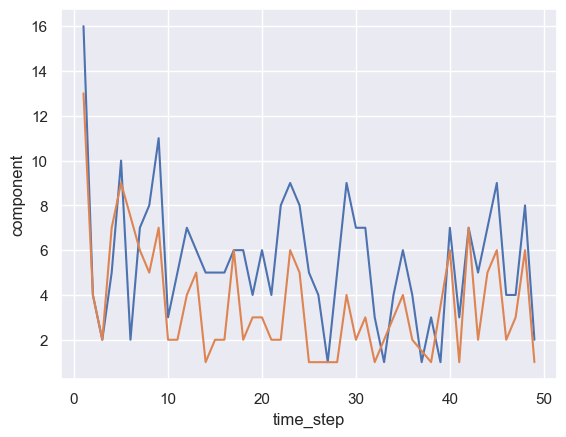

In [126]:
pr = comps_data.drop_duplicates(["time_step", "component"]).groupby("time_step")["component"].nunique().reset_index()
sns.lineplot(x=pr["time_step"], y=pr["component"])
pr = comps_data_no_bad.drop_duplicates(["time_step", "component"]).groupby("time_step")["component"].nunique().reset_index()
sns.lineplot(x=pr["time_step"], y=pr["component"])


In [128]:
comps_data[
    comps_data["address_id"].isin(bad_input)
].shape, comps_data.shape

((516, 3), (10725, 3))

In [ ]:
comps_data[
    comps_data["address_id"].isin(in_output)
].shape, comps_data.shape

((526, 3), (10725, 3))

In [131]:
addr_classes[addr_classes["address"].isin(comps_data_no_bad["address_id"])]["class"].value_counts()

class
3    1751
2     348
1       4
Name: count, dtype: int64

In [132]:
addr_classes[addr_classes["address"].isin(comps_data["address_id"])]["class"].value_counts()

class
3    7180
2    2799
1      11
Name: count, dtype: int64

In [139]:
11 / addr_classes[addr_classes["address"].isin(comps_data["address_id"])].shape[0]

0.0011011011011011012

In [138]:
addr_classes["class"].value_counts()[1] / addr_classes["class"].shape[0]

0.017335365068255115

In [24]:
addr_to_addr_edges[addr_to_addr_edges["Time step"] == 2]["input_address"].nunique()

8115

In [145]:
comps_data_no_bad_5 = None
for ts in range(1, 50, 5):
    # print(ts)
    comps, cnt = get_scc_data(
        addr_to_addr_edges1[(addr_to_addr_edges1["Time step"] >= ts) & (addr_to_addr_edges1["Time step"] < ts + 5)]
    )
    comps["time_step"] = ts
    if comps_data_no_bad_5 is None:
        comps_data_no_bad_5 = comps
    else:
        comps_data_no_bad_5 = pd.concat([comps_data_no_bad_5, comps])

In [146]:
comps_data_no_bad_5

,address_id,component,time_step
1771,1NVXBQnriS27Z6hxC1CaCTK4YeQJdSEQBq,1771,1
1772,1GydRBoR4myB3AhJQgRzYZ8vfp1B5gN5T5,1771,1
3758,15jA9KLumBDxDySc266kFTgAvfbTNsVAoW,3757,1
3759,19wsjMWgNEaJdXSuCD62MmbvJCZ44LKPo7,3757,1
5326,18gUF76aKAM2WFgg6s75BfTroExWe7JLkJ,5324,1
...,...,...,...
13236,1Fr8qEa7vcwJikeW9q6thaYZPacGY5CQAb,13151,46
13237,1CneiLxRzxGXJEQwVHjegGNtFJRoVF2mxv,13151,46
13238,1BnRf3dKkPhZ5P5DGgYUFAB3CHPp1TVcFH,13151,46
13239,1H1WS2tFx5yCsxtefs9PSTdqVX2mduyf3b,13151,46


<Axes: xlabel='time_step', ylabel='component'>

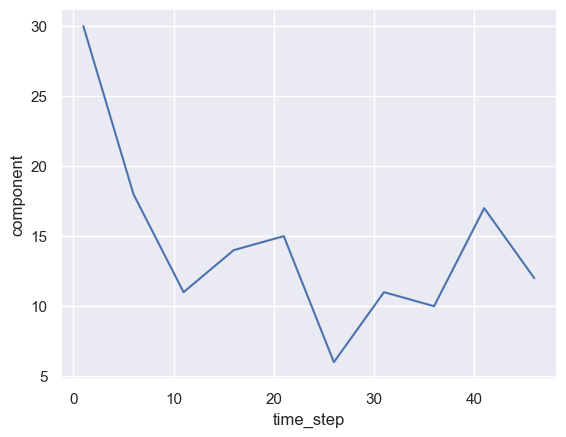

In [147]:
pr = comps_data_no_bad_5.drop_duplicates(["time_step", "component"]).groupby("time_step")["component"].nunique().reset_index()
sns.lineplot(x=pr["time_step"], y=pr["component"])

In [148]:
addr_classes[addr_classes["address"].isin(comps_data_no_bad_5["address_id"])]["class"].value_counts()

class
3    2117
2     400
1       4
Name: count, dtype: int64

In [150]:
comps_data_no_bad_10 = None
for ts in range(1, 50, 5):
    # print(ts)
    comps, cnt = get_scc_data(
        addr_to_addr_edges1[(addr_to_addr_edges1["Time step"] >= ts) & (addr_to_addr_edges1["Time step"] < ts + 10)]
    )
    comps["time_step"] = ts
    if comps_data_no_bad_10 is None:
        comps_data_no_bad_10 = comps
    else:
        comps_data_no_bad_10 = pd.concat([comps_data_no_bad_10, comps])

In [153]:
addr_classes[addr_classes["address"].isin(comps_data_no_bad_10["address_id"])]["class"].value_counts()

class
3    2208
2     469
1      11
Name: count, dtype: int64

<Axes: xlabel='time_step', ylabel='component'>

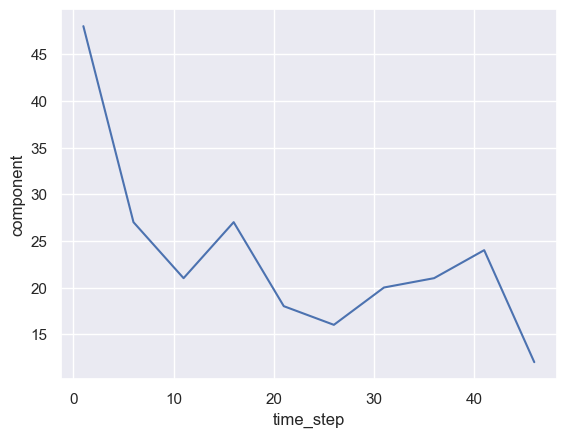

In [154]:
pr = comps_data_no_bad_10.drop_duplicates(["time_step", "component"]).groupby("time_step")["component"].nunique().reset_index()
sns.lineplot(x=pr["time_step"], y=pr["component"])

# Итоги

Фродеры не склонны к тому, чтобы вливаться в компоненты сильной связности (менее сколлы, чем легальные), возможно стоит добавить признак - 

Состоял ли адрес в КСС в каком-то разрезе (1 / 5 / 10 последовательных timesteps)